## Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-08-08 01:11:53.135888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754615513.341417      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754615513.398688      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Pipeline Configuration

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = "/kaggle/input/daisee-engagement-confussion-dataset-balanced"
AUTOTUNE = tf.data.AUTOTUNE

## Data Visualization


[Split: train]
 Label 0: 2093 gambar
 Label 1: 1995 gambar
  Total: 4088 gambar

[Split: val]
 Label 0: 448 gambar
 Label 1: 428 gambar
  Total: 876 gambar

[Split: test]
 Label 0: 449 gambar
 Label 1: 427 gambar
  Total: 876 gambar


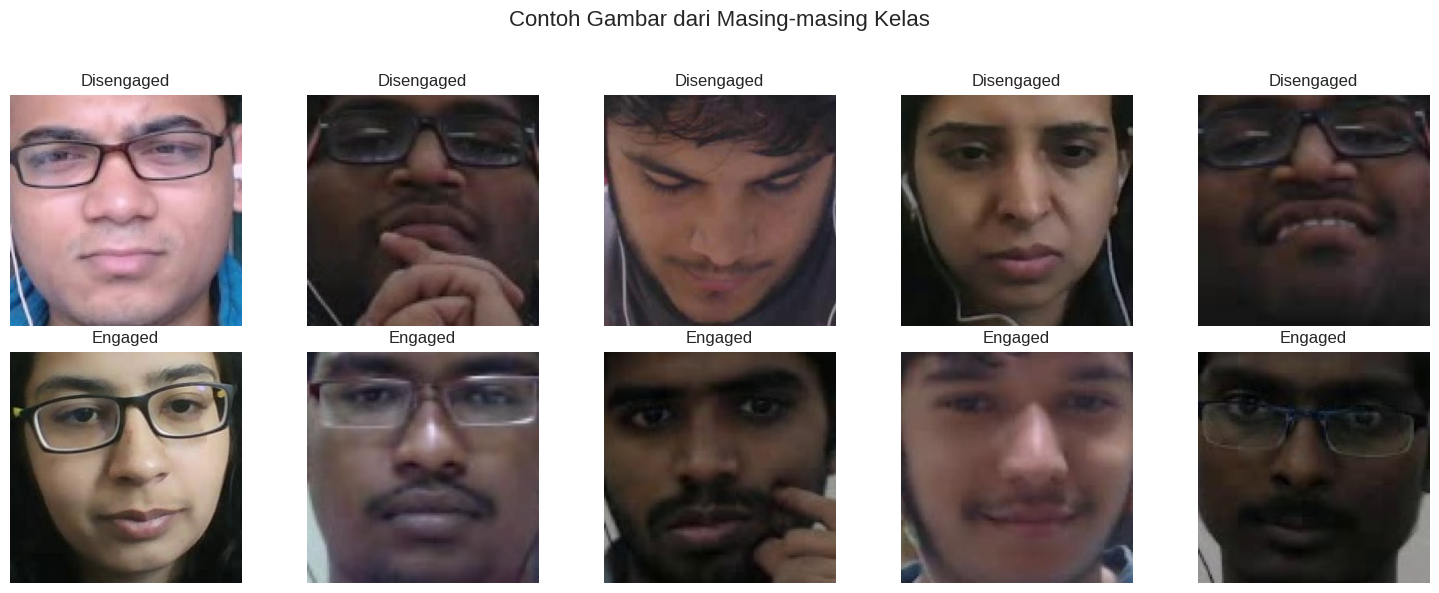

In [28]:
for split in ['train', 'val', 'test']:
    total = 0
    print(f"\n[Split: {split}]")
    for label in ['0', '1']:
        dir_path = os.path.join(DATA_DIR, split, label)
        if os.path.exists(dir_path):
            count = len(os.listdir(dir_path))
            print(f" Label {label}: {count} gambar")
            total += count
        else:
            print(f" Direktori tidak ditemukan: {dir_path}")
    print(f"  Total: {total} gambar")

dataset_path = os.path.join(DATA_DIR, 'train')
labels = {'0': 'Disengaged', '1': 'Engaged'}

if os.path.exists(dataset_path):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Contoh Gambar dari Masing-masing Kelas", fontsize=16)

    for i, label in enumerate(['0', '1']):
        class_dir = os.path.join(dataset_path, label)
        if os.path.exists(class_dir):
            all_images = os.listdir(class_dir)
            if all_images:
                sample_images = random.sample(all_images, min(5, len(all_images)))
                
                for j, img_name in enumerate(sample_images):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = mpimg.imread(img_path)
                        ax = axes[i][j]
                        ax.imshow(img)
                        ax.axis('off')
                        ax.set_title(f"{labels[label]}")
                    except Exception as e:
                        print(f"Gagal memuat gambar: {img_path}, error: {str(e)}")
            else:
                print(f"Tidak ada gambar di direktori: {class_dir}")
        else:
            print(f"Direktori label tidak ditemukan: {class_dir}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('data_samples.png')
    plt.show()
else:
    print(f"Direktori training tidak ditemukan: {dataset_path}")

## Data Preparation & Model Architecture

### Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.02),
    tf.keras.layers.RandomContrast(0.08),
    tf.keras.layers.RandomBrightness(0.05),
    tf.keras.layers.RandomTranslation(0.02, 0.02),
])

I0000 00:00:1754615714.158546      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Data Normalization

In [5]:
def preprocess_input(x):
    return tf.keras.applications.resnet50.preprocess_input(x)

## Model Architecture

### Load Base Model ResNet-50

In [6]:
base_model = ResNet50(
    name='resnet50_base',
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,),
    pooling='avg',
)
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Model Construction

In [7]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.7)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name='engagement_classifier')

In [8]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "engagement_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_base       │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50_base[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Preparing Dataset

In [9]:
def prepare_dataset(directory, shuffle=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    return ds.prefetch(AUTOTUNE)

train_ds = prepare_dataset(os.path.join(DATA_DIR, 'train'), shuffle=True)
val_ds = prepare_dataset(os.path.join(DATA_DIR, 'val'))
test_ds = prepare_dataset(os.path.join(DATA_DIR, 'test'))

Found 4088 files belonging to 2 classes.
Found 876 files belonging to 2 classes.
Found 876 files belonging to 2 classes.


## Training Stage 1

In [10]:
checkpoint_path = "best_model.keras"

callbacks_phase1 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ), 
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
]

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks_phase1
)

Epoch 1/100


I0000 00:00:1754615770.427427      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5243 - loss: 0.9825
Epoch 1: val_accuracy improved from -inf to 0.57078, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.5242 - loss: 0.9823 - val_accuracy: 0.5708 - val_loss: 0.7043
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5357 - loss: 0.8924
Epoch 2: val_accuracy improved from 0.57078 to 0.57192, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5356 - loss: 0.8923 - val_accuracy: 0.5719 - val_loss: 0.6884
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5483 - loss: 0.8537
Epoch 3: val_accuracy improved from 0.57192 to 0.58676, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5482 - loss: 0.8538 - val_accuracy: 0.5868 - val_loss: 0.6766
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5501 - loss: 0.8428
Epoch 4: val_accuracy improved from 

## Fine Tuning ResNet-50

In [11]:
model = tf.keras.models.load_model(checkpoint_path)

base_model = model.get_layer('resnet50_base')
base_model.trainable = True

# bekukan seluruh layer daahulu
for layer in base_model.layers:
    layer.trainable = False

# unfreeze hanya layer conv5
for layer in base_model.layers:
    if layer.name.startswith('conv5_'):
        layer.trainable = True

print("\nLayer yang di-unfreeze:")
for layer in base_model.layers:
    if layer.trainable:
        print(f"- {layer.name}")


Layer yang di-unfreeze:
- conv5_block1_1_conv
- conv5_block1_1_bn
- conv5_block1_1_relu
- conv5_block1_2_conv
- conv5_block1_2_bn
- conv5_block1_2_relu
- conv5_block1_0_conv
- conv5_block1_3_conv
- conv5_block1_0_bn
- conv5_block1_3_bn
- conv5_block1_add
- conv5_block1_out
- conv5_block2_1_conv
- conv5_block2_1_bn
- conv5_block2_1_relu
- conv5_block2_2_conv
- conv5_block2_2_bn
- conv5_block2_2_relu
- conv5_block2_3_conv
- conv5_block2_3_bn
- conv5_block2_add
- conv5_block2_out
- conv5_block3_1_conv
- conv5_block3_1_bn
- conv5_block3_1_relu
- conv5_block3_2_conv
- conv5_block3_2_bn
- conv5_block3_2_relu
- conv5_block3_3_conv
- conv5_block3_3_bn
- conv5_block3_add
- conv5_block3_out


In [12]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "engagement_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_base       │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50_base[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 14,978,049 (57.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

## Training Stage 2

In [13]:
callbacks_phase2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="fine_tuned_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1,
    ),
]

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks_phase2
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6393 - loss: 0.6696
Epoch 1: val_accuracy improved from -inf to 0.72032, saving model to fine_tuned_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.6394 - loss: 0.6695 - val_accuracy: 0.7203 - val_loss: 0.5684 - learning_rate: 1.0000e-05
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6982 - loss: 0.5806
Epoch 2: val_accuracy improved from 0.72032 to 0.74543, saving model to fine_tuned_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.6983 - loss: 0.5805 - val_accuracy: 0.7454 - val_loss: 0.5371 - learning_rate: 1.0000e-05
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7472 - loss: 0.5170
Epoch 3: val_accuracy improved from 0.74543 to 0.76941, saving model to fine_tuned_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.7472 - loss: 0.5171 - val_accuracy: 0.7694 - val_loss: 0.4988 - learning_rate: 1.0000e-05
Epoch 4

## Evaluasi

In [14]:
model = tf.keras.models.load_model("fine_tuned_model.keras") 
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9424 - loss: 0.1272
Test Accuracy: 0.9361 | Test Loss: 0.1456


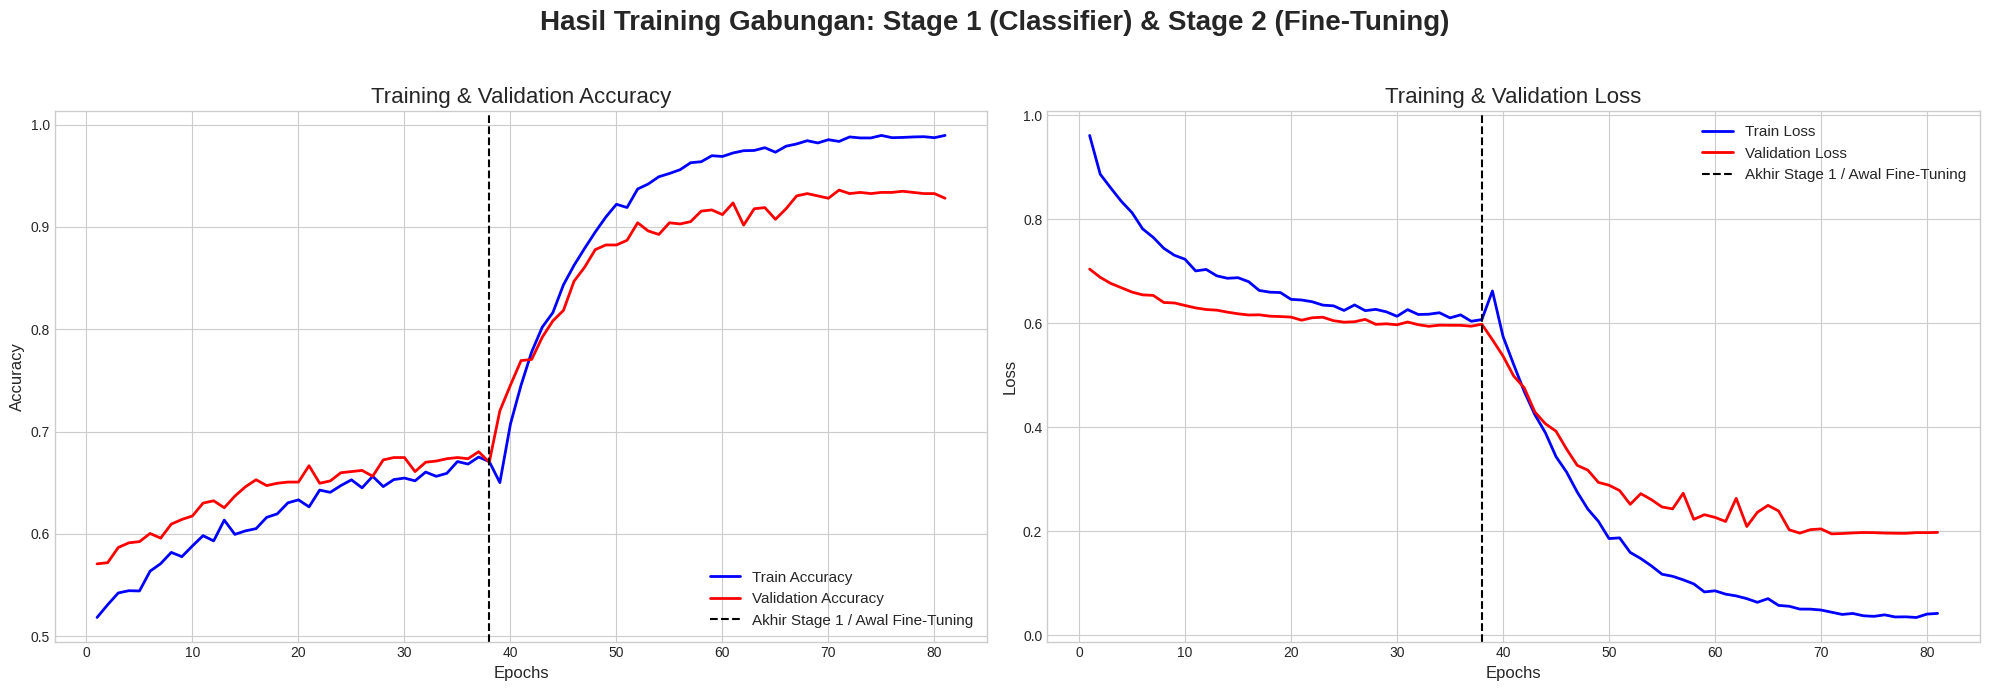

In [15]:
def plot_combined_training_history(history1, history2):
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']
    
    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    total_acc = acc1 + acc2
    total_val_acc = val_acc1 + val_acc2
    total_loss = loss1 + loss2
    total_val_loss = val_loss1 + val_loss2

    # Membuat rentang epoch untuk keseluruhan proses training
    epochs = range(1, len(total_acc) + 1)
    
    # Menentukan titik di mana stage 1 berakhir
    stage1_end_epoch = len(acc1)


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Hasil Training Gabungan: Stage 1 (Classifier) & Stage 2 (Fine-Tuning)', fontsize=20, weight='bold')

    # Plot Akurasi
    ax1.plot(epochs, total_acc, 'b-', label='Train Accuracy', lw=2)
    ax1.plot(epochs, total_val_acc, 'r-', label='Validation Accuracy', lw=2)
    
    # Menambahkan garis vertikal sebagai pemisah antar stage
    ax1.axvline(x=stage1_end_epoch, color='k', linestyle='--', label='Akhir Stage 1 / Awal Fine-Tuning')
    ax1.set_title('Training & Validation Accuracy', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.grid(True)

    # Plot Loss
    ax2.plot(epochs, total_loss, 'b-', label='Train Loss', lw=2)
    ax2.plot(epochs, total_val_loss, 'r-', label='Validation Loss', lw=2)
    
    # Menambahkan garis vertikal sebagai pemisah antar stage
    ax2.axvline(x=stage1_end_epoch, color='k', linestyle='--', label='Akhir Stage 1 / Awal Fine-Tuning')
    ax2.set_title('Training & Validation Loss', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right', fontsize=11)
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_combined_training_history(history_stage1, history_stage2)

In [16]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs).flatten()

y_pred = (y_pred_probs > 0.5).astype(int)


target_names = ['Disengaged (Kelas 0)', 'Engaged (Kelas 1)']

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

Disengaged (Kelas 0)       0.95      0.92      0.94       449
   Engaged (Kelas 1)       0.92      0.95      0.94       427

            accuracy                           0.94       876
           macro avg       0.94      0.94      0.94       876
        weighted avg       0.94      0.94      0.94       876



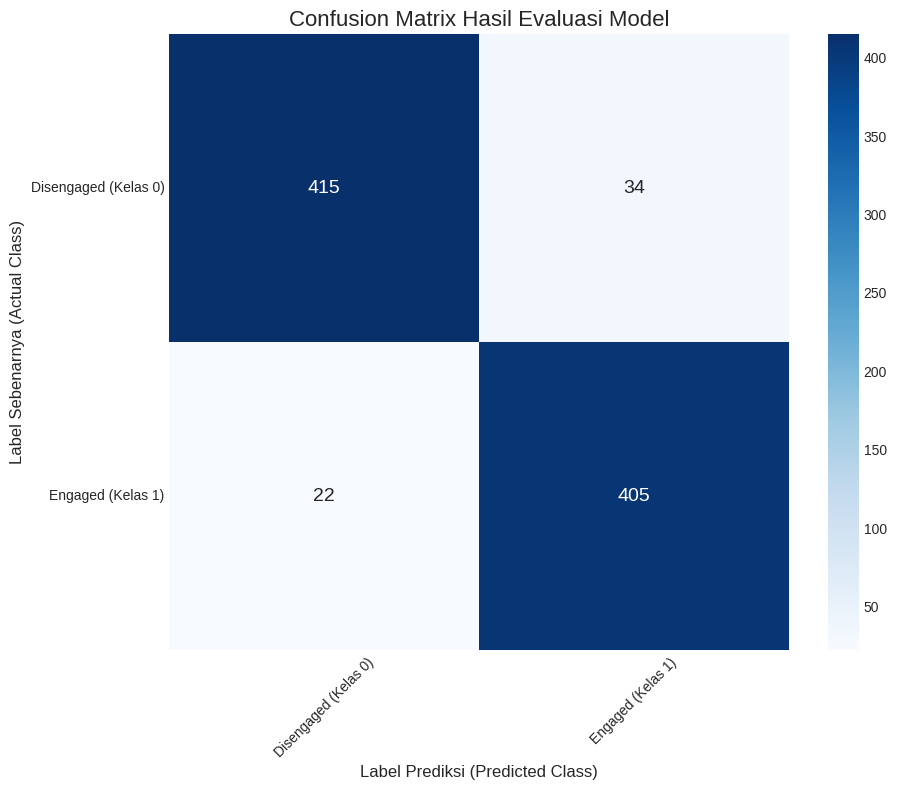

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            annot_kws={"size": 14})

plt.title('Confusion Matrix Hasil Evaluasi Model', fontsize=16)
plt.ylabel('Label Sebenarnya (Actual Class)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Class)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Eksperimen Tanpa Data Augmentasi

### Load Base Model

In [18]:
base_model_no_aug = ResNet50(
    name='resnet50_base_no_aug',
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,),
    pooling='avg',)

base_model_no_aug.trainable = False

### Model Construction Without Augmentation

In [19]:
inputs_no_aug = tf.keras.Input(shape=IMG_SIZE + (3,))
x_no_aug = preprocess_input(inputs_no_aug) 
x_no_aug = base_model_no_aug(x_no_aug, training=False)
x_no_aug = tf.keras.layers.Dropout(0.75)(x_no_aug)
outputs_no_aug = tf.keras.layers.Dense(1, activation='sigmoid')(x_no_aug)

model_no_aug = tf.keras.Model(inputs_no_aug, outputs_no_aug, name='engagement_classifier_no_aug')

In [20]:
model_no_aug.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_no_aug.summary()

Model: "engagement_classifier_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_base_no_a… │ (None, 2048)      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ resnet50_base_no… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
checkpoint_path_no_aug = "best_model_no_aug.keras"

callbacks_phase1_no_aug = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_no_aug,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
]

history_stage1_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks_phase1_no_aug
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4810 - loss: 1.0949
Epoch 1: val_accuracy improved from -inf to 0.52397, saving model to best_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.4811 - loss: 1.0947 - val_accuracy: 0.5240 - val_loss: 0.7203
Epoch 2/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5055 - loss: 1.0135
Epoch 2: val_accuracy improved from 0.52397 to 0.52626, saving model to best_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5055 - loss: 1.0131 - val_accuracy: 0.5263 - val_loss: 0.6983
Epoch 3/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5102 - loss: 0.9630
Epoch 3: val_accuracy improved from 0.52626 to 0.54909, saving model to best_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5103 - loss: 0.9628 - val_accuracy: 0.5491 - val_loss: 0.6826
Epoch 4/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5210 - loss: 0.9028
Epoch 4

In [23]:
model_no_aug = tf.keras.models.load_model(checkpoint_path_no_aug)

base_model_no_aug = model_no_aug.get_layer('resnet50_base_no_aug')
base_model_no_aug.trainable = True

for layer in base_model_no_aug.layers:
    if not layer.name.startswith('conv5_'):
        layer.trainable = False

model_no_aug.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_no_aug.summary()

Model: "engagement_classifier_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_base_no_a… │ (None, 2048)      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ resnet50_base_no… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 14,978,049 (57.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [24]:
callbacks_phase2_no_aug = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="fine_tuned_model_no_aug.keras",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1,
    ),
]

history_stage2_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks_phase2_no_aug
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6378 - loss: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.73973, saving model to fine_tuned_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.6380 - loss: 0.7161 - val_accuracy: 0.7397 - val_loss: 0.5169 - learning_rate: 1.0000e-05
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7565 - loss: 0.5071
Epoch 2: val_accuracy improved from 0.73973 to 0.78881, saving model to fine_tuned_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.7566 - loss: 0.5071 - val_accuracy: 0.7888 - val_loss: 0.4527 - learning_rate: 1.0000e-05
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8160 - loss: 0.3962
Epoch 3: val_accuracy improved from 0.78881 to 0.83904, saving model to fine_tuned_model_no_aug.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8160 - loss: 0.3962 - val_accuracy: 0.8390 - val_loss: 0.3904 - learning_rate: 1

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9534 - loss: 0.1488


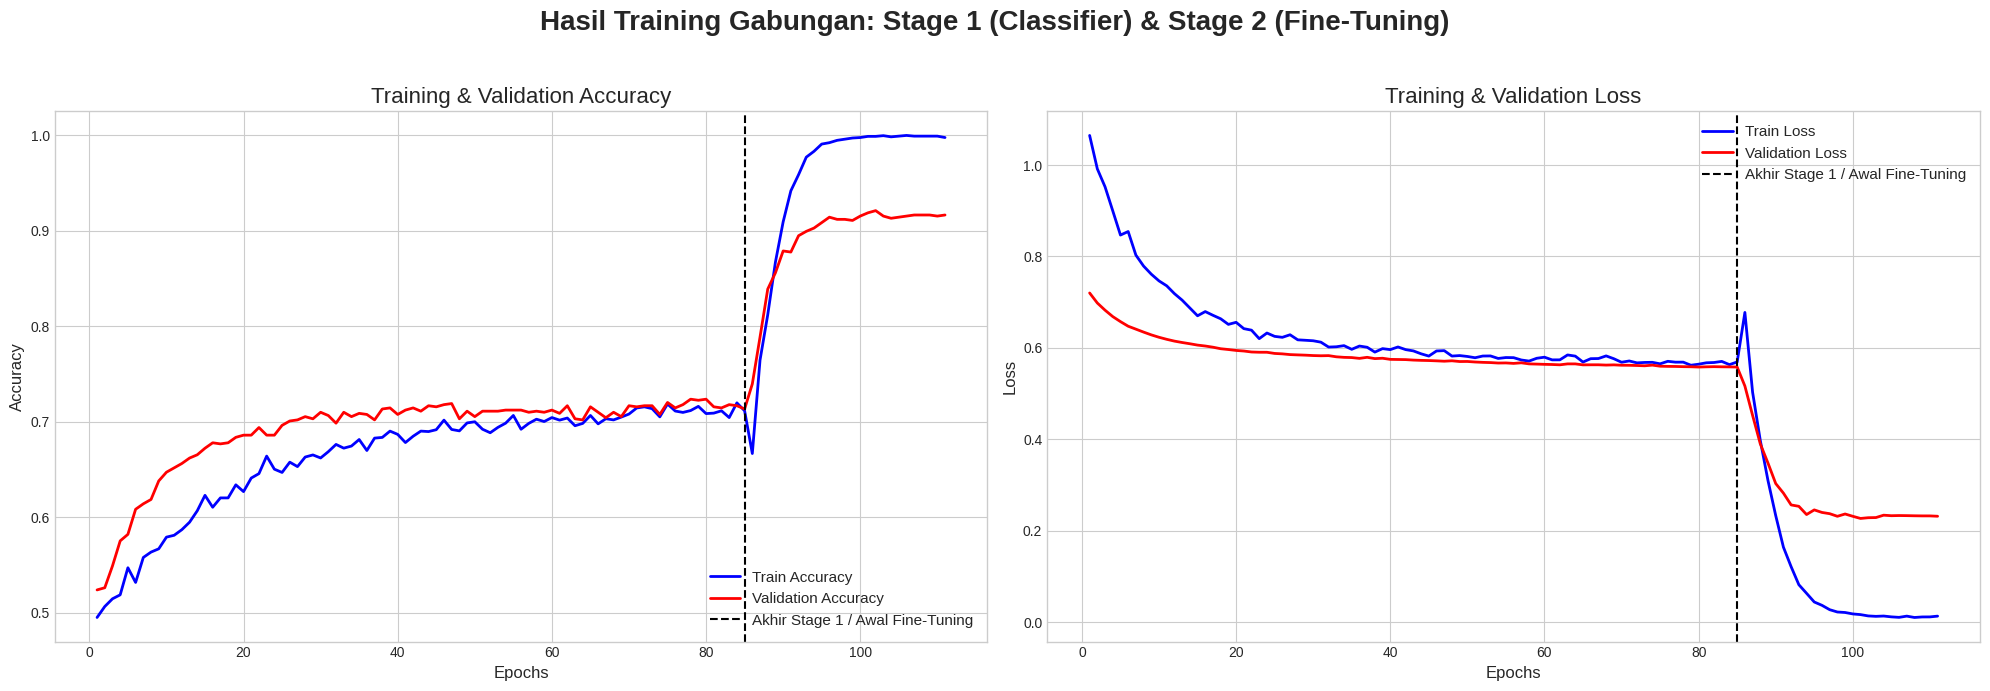

In [25]:
model_no_aug = tf.keras.models.load_model("fine_tuned_model_no_aug.keras")
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_ds)

plot_combined_training_history(history_stage1_no_aug, history_stage2_no_aug)

Hasil percobaan menunjukan adanya overfiting yang dapat dilihat pada grafil accuracy dan loss pelatihan jika tidak menerapkan data Augmentasi.

In [26]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model_no_aug.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs).flatten()

y_pred = (y_pred_probs > 0.5).astype(int)


target_names = ['Disengaged (Kelas 0)', 'Engaged (Kelas 1)']

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

Disengaged (Kelas 0)       0.95      0.94      0.95       449
   Engaged (Kelas 1)       0.94      0.95      0.95       427

            accuracy                           0.95       876
           macro avg       0.95      0.95      0.95       876
        weighted avg       0.95      0.95      0.95       876



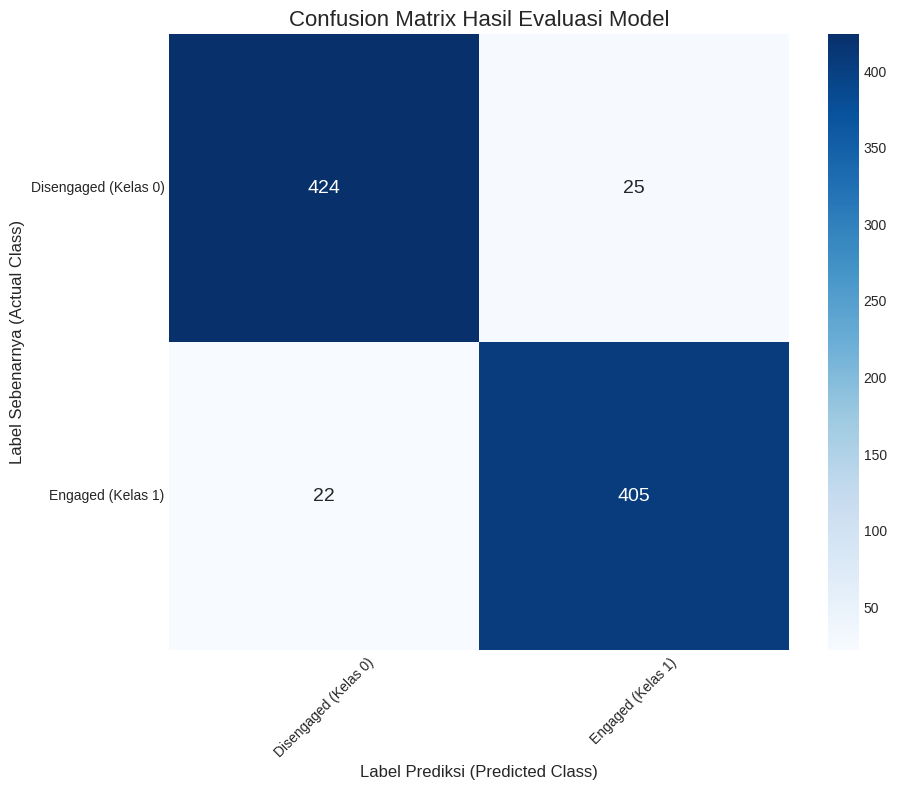

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            annot_kws={"size": 14})

plt.title('Confusion Matrix Hasil Evaluasi Model', fontsize=16)
plt.ylabel('Label Sebenarnya (Actual Class)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Class)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()